## Scrapping Amazon Electronics - One Time Collection

In [ ]:
# --- Imports & Setup ---
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager

# --- Initialize Selenium WebDriver ---
options = Options()
options.add_argument('--start-maximized')
options.add_argument('--disable-blink-features=AutomationControlled')
options.add_experimental_option('excludeSwitches', ['enable-automation'])
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# --- Category URLs ---
category_urls = {
    "Smartphones": "https://www.amazon.in/s?k=smartphones",
    "Laptops": "https://www.amazon.in/s?k=laptops",
    "Smartwatches": "https://www.amazon.in/s?k=smartwatches",
    "Headphones": "https://www.amazon.in/s?k=headphones",
    "Televisions": "https://www.amazon.in/s?k=televisions",
    "Air Conditioners": "https://www.amazon.in/s?k=air+conditioners",
    "Washing Machines": "https://www.amazon.in/s?k=washing+machines",
    "Microwaves": "https://www.amazon.in/s?k=microwave",
    "Refrigerators": "https://www.amazon.in/s?k=refrigerators",
    "Tablets": "https://www.amazon.in/s?k=tablets"
}

# --- Scraping Function ---
def scrape_amazon_category(category_name, url):
    print(f"Scraping category: {category_name}")
    driver.get(url)
    time.sleep(3)
    
    products = []
    items = driver.find_elements(By.XPATH, '//div[@data-component-type="s-search-result"]')[:10]

    for item in items:
        try:
            name = item.find_element(By.XPATH, ".//span[@class='a-size-medium a-color-base a-text-normal']").text
        except:
            name = None
        try:
            price = item.find_element(By.XPATH, ".//span[@class='a-price-whole']").text.replace(',', '')
        except:
            price = None
        try:
            og_price = item.find_element(By.XPATH, ".//span[@class='a-price a-text-price']//span[@class='a-offscreen']").text.replace(',', '')
        except:
            og_price = None
        try:
            rating = item.find_element(By.XPATH, ".//span[@class='a-icon-alt']").text
        except:
            rating = None
        try:
            reviews = item.find_element(By.XPATH, ".//span[@class='a-size-base s-underline-text']").text
        except:
            reviews = None
        try:
            product_url = item.find_element(By.XPATH, ".//h2/a").get_attribute("href")
        except:
            product_url = None

        products.append({
            "Category": category_name,
            "Product Name": name,
            "Price (INR)": price,
            "Original Price": og_price,
            "Rating": rating,
            "Number of Reviews": reviews,
            "Product URL": product_url
        })

    return products

# --- Run Scraping for All Categories ---
all_amazon_products = []
for category, url in category_urls.items():
    products = scrape_amazon_category(category, url)
    all_amazon_products.extend(products)
    time.sleep(2)

# --- Save to CSV ---
amazon_df = pd.DataFrame(all_amazon_products)
amazon_df["Timestamp"] = pd.Timestamp.now()
amazon_df.to_csv("amazon_electronics.csv", index=False)

print("✅ Amazon scraping completed and saved to 'amazon_electronics.csv'")
driver.quit()

## Scrapping Paytm Mall - One Time Collection

In [ ]:
# PAYTM MALL Scraper
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
import time
import pandas as pd

options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--disable-gpu')
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

category_urls = {
    "Smartphones": "https://paytmmall.com/shop/search?q=smartphones",
    "Laptops": "https://paytmmall.com/shop/search?q=laptops",
    "Smartwatches": "https://paytmmall.com/shop/search?q=smartwatches",
    "Headphones": "https://paytmmall.com/shop/search?q=headphones",
    "AC": "https://paytmmall.com/shop/search?q=air+conditioners",
    "TV": "https://paytmmall.com/shop/search?q=television",
    "Washing Machine": "https://paytmmall.com/shop/search?q=washing+machine",
    "Microwave": "https://paytmmall.com/shop/search?q=microwave",
    "Refrigerator": "https://paytmmall.com/shop/search?q=refrigerator",
    "Tablets": "https://paytmmall.com/shop/search?q=tablets"
}

data = []

for category, url in category_urls.items():
    driver.get(url)
    time.sleep(3)
    
    products = driver.find_elements(By.CSS_SELECTOR, ".UGUy")
    prices = driver.find_elements(By.CSS_SELECTOR, "._1kMS")
    
    for prod, price in zip(products[:10], prices[:10]):
        data.append({
            "Category": category,
            "Product Name": prod.text,
            "Price": price.text,
            "Website": "Paytm Mall"
        })

driver.quit()
df = pd.DataFrame(data)
df.to_csv("paytm_electronics.csv", index=False)

## Cleaning and Merging Files

In [ ]:
import pandas as pd

# Load datasets
amazon = pd.read_csv("amazon_electronics.csv")
paytm = pd.read_csv("paytm_electronics.csv")
kaggle = pd.read_csv("electronics_products_pricing.csv")

# Clean Amazon
amazon_clean = amazon.copy()
amazon_clean["platform"] = "Amazon"
amazon_clean["product_name"] = amazon_clean["Product Name"].fillna("Unknown Product")
amazon_clean["price_inr"] = amazon_clean["Price (INR)"]
amazon_clean["rating"] = amazon_clean["Rating"]
amazon_clean["reviews"] = amazon_clean["Number of Reviews"]
amazon_clean["category"] = amazon_clean["Category"]
amazon_clean["original_price"] = amazon_clean["Original Price"]
amazon_clean["url"] = amazon_clean["Product URL"]
amazon_clean = amazon_clean[["platform", "category", "product_name", "price_inr", "original_price", "rating", "reviews", "url"]]

# Clean Paytm
paytm_clean = paytm.copy()
paytm_clean["platform"] = "Paytm Mall"
paytm_clean["price_inr"] = paytm_clean["Price"]
paytm_clean["product_name"] = paytm_clean["Product Name"]
paytm_clean["category"] = paytm_clean["Category"]
paytm_clean["rating"] = paytm_clean["Rating"]
paytm_clean["original_price"] = None
paytm_clean["reviews"] = None
paytm_clean["url"] = None
paytm_clean = paytm_clean[["platform", "category", "product_name", "price_inr", "original_price", "rating", "reviews", "url"]]

# Clean Kaggle
kaggle_clean = kaggle.copy()
kaggle_clean["platform"] = kaggle_clean["prices.merchant"]
kaggle_clean["product_name"] = kaggle_clean["name"]
kaggle_clean["price_inr"] = kaggle_clean["price"].apply(lambda x: round(x * 83, 2) if pd.notnull(x) else None)
kaggle_clean["category"] = kaggle_clean["primaryCategories"]
kaggle_clean["rating"] = None
kaggle_clean["reviews"] = None
kaggle_clean["original_price"] = None
kaggle_clean["url"] = kaggle_clean["sourceURLs"]
kaggle_clean = kaggle_clean[["platform", "category", "product_name", "price_inr", "original_price", "rating", "reviews", "url"]]

# Combine all
combined_df = pd.concat([amazon_clean, paytm_clean, kaggle_clean], ignore_index=True)

# Final clean-up
combined_df.drop_duplicates(subset=["platform", "product_name", "price_inr"], inplace=True)
combined_df.dropna(subset=["product_name", "price_inr"], inplace=True)

# Export cleaned merged data
combined_df.to_csv("combined_cleaned_electronics.csv", index=False)

combined_df.head()

,platform,category,product_name,price_inr,original_price,rating,reviews,url
0,Amazon,Smartphones,Unknown Product,30998.0,NaN,NaN,402,NaN
1,Amazon,Smartphones,Unknown Product,72900.0,NaN,NaN,523,NaN
2,Amazon,Smartphones,Unknown Product,6498.0,NaN,NaN,"2,875",NaN
3,Amazon,Smartphones,Unknown Product,13998.0,NaN,NaN,"3,888",NaN
4,Amazon,Smartphones,Unknown Product,8498.0,NaN,NaN,"2,711",NaN


## Removing Price Outliers (IQR Method)

In [7]:
import pandas as pd

# Load the cleaned dataset
df = pd.read_csv("combined_cleaned_electronics.csv")

# Ensure the 'Price' column is numeric
df['price_inr'] = pd.to_numeric(df['price_inr'], errors='coerce')

# Drop rows with missing prices just in case
df.dropna(subset=['price_inr'], inplace=True)

# --- IQR Method to Remove Outliers ---
Q1 = df['price_inr'].quantile(0.25)
Q3 = df['price_inr'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter data within IQR bounds
filtered_df = df[(df['price_inr'] >= lower_bound) & (df['price_inr'] <= upper_bound)]

print("Original dataset shape:", df.shape)
print("Filtered dataset shape (IQR applied):", filtered_df.shape)

# Save the filtered data
filtered_df.to_csv("final_filtered_electronics_dataset.csv", index=False)
print("Filtered dataset saved as 'final_filtered_electronics_dataset.csv'")

Original dataset shape: (5150, 8)
Filtered dataset shape (IQR applied): (4515, 8)
Filtered dataset saved as 'final_filtered_electronics_dataset.csv'


## Generating Feature Columns

In [12]:
import pandas as pd

# Load the dataset
df = pd.read_csv("final_filtered_electronics_dataset.csv")

# 1. Price Category (Low, Medium, High based on INR price quantiles)
df['Price Category'] = pd.qcut(df['price_inr'], q=3, labels=['Low', 'Medium', 'High'])

# 2. Discount Percentage (from original price and current price)
df['Discount %'] = ((df['original_price'] - df['price_inr']) / df['original_price']) * 100
df['Discount %'] = df['Discount %'].fillna(0).clip(lower=0)  # Remove negative discounts

# 3. Product Name Length (number of characters)
df['Product Name Length'] = df['product_name'].astype(str).apply(len)

# 4. Word Count in Product Name
df['Product Name Word Count'] = df['product_name'].astype(str).apply(lambda x: len(x.split()))

# 5. Is Discounted (flag if discount words are in product name)
discount_keywords = ['discount', 'offer', 'deal', 'sale', 'off', 'save']
df['Is Discounted'] = df['product_name'].str.lower().apply(
    lambda x: any(word in x for word in discount_keywords)
)

# 6. Platform-Category Combo
df['Platform_Category'] = df['platform'] + " - " + df['category']

# Save the enriched dataset
df.to_csv("electronics_with_features.csv", index=False)

print("✅ Feature columns created and saved as 'electronics_with_features.csv'")

✅ Feature columns created and saved as 'electronics_with_features.csv'


## Competitor Analysis

In [13]:
# Import necessary libraries
import pandas as pd

# Load the latest cleaned dataset
df = pd.read_csv('electronics_with_features.csv')

# Step 1: Basic Cleaning again (safe side)
df['product_name'] = df['product_name'].str.strip().str.lower()

# Step 2: Pivot the dataset to compare prices across platforms
pivot_df = df.pivot_table(index='product_name', columns='platform', values='price_inr', aggfunc='min')

# Display a sample to check
print(pivot_df.head())

# Step 3: Create new columns for price comparison
# Example: Difference between Amazon and Paytm
if 'amazon' in pivot_df.columns and 'paytm' in pivot_df.columns:
    pivot_df['price_diff_amazon_vs_paytm'] = pivot_df['amazon'] - pivot_df['paytm']

# Example: Difference between Amazon and any other platform (if available)
platforms = pivot_df.columns.tolist()
for i in range(len(platforms)):
    for j in range(i+1, len(platforms)):
        pivot_df[f'price_diff_{platforms[i]}_vs_{platforms[j]}'] = pivot_df[platforms[i]] - pivot_df[platforms[j]]

# Step 4: Save the pivot data
pivot_df.to_csv('competitor_price_comparison.csv', index=True)

print("✅ Competitor price comparison table created and saved as 'competitor_price_comparison.csv'")

platform                                            1 Stop Electronics Center, Inc.  \
product_name                                                                          
1080p day/night ptz speed dome camera with 5 to...                              NaN   
10tb g-drive with thunderbolt                                                   NaN   
120 bulb led video light (daylight)                                             NaN   
128gb ipod touch (gold) (6th generation)                                        NaN   
128gb ipod touch (space gray) (6th generation)                                  NaN   

platform                                            17th St Photo Supply Inc  \
product_name                                                                   
1080p day/night ptz speed dome camera with 5 to...                       NaN   
10tb g-drive with thunderbolt                                            NaN   
120 bulb led video light (daylight)                                   

## Visualizations

Available columns in pivot_df: Index(['product_name', '1 Stop Electronics Center, Inc.',
       '17th St Photo Supply Inc', '19th Hole Deals', '1topwire', '1win',
       '2011dailydeals', '305mia65', '428ypz', '47st. Photo',
       ...
       'price_diff_yogi-comp_vs_your-best-store',
       'price_diff_yogi-comp_vs_zal-digital',
       'price_diff_yogi-comp_vs_zara4573', 'price_diff_yogi-comp_vs_zoneusa',
       'price_diff_your-best-store_vs_zal-digital',
       'price_diff_your-best-store_vs_zara4573',
       'price_diff_your-best-store_vs_zoneusa',
       'price_diff_zal-digital_vs_zara4573',
       'price_diff_zal-digital_vs_zoneusa', 'price_diff_zara4573_vs_zoneusa'],
      dtype='object', length=157642)


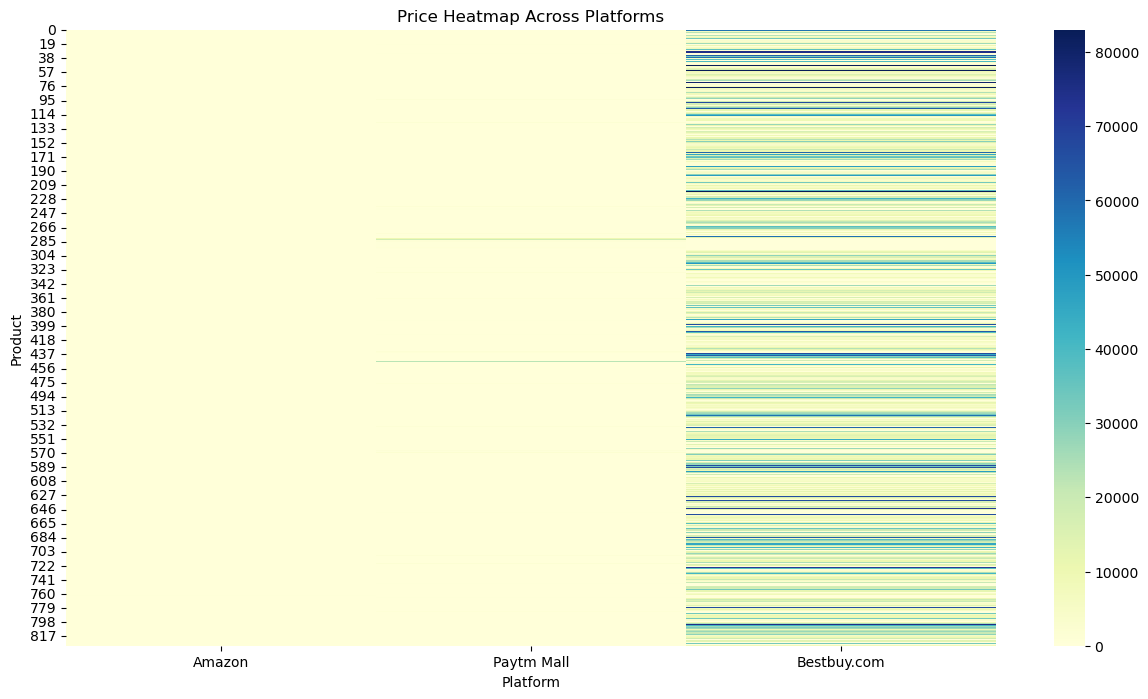

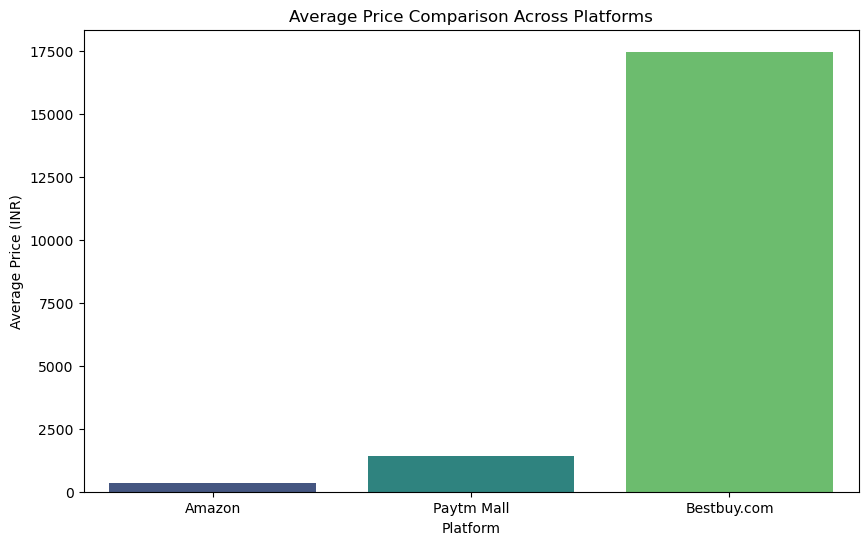

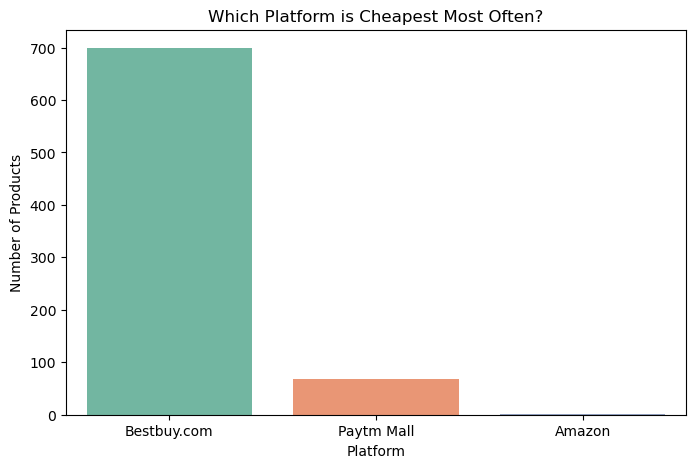

In [15]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the competitor price comparison file
pivot_df = pd.read_csv('competitor_price_comparison.csv')

# Verify column names in pivot_df
print("Available columns in pivot_df:", pivot_df.columns)

# Replace 'amazon', 'paytm', 'croma' with actual column names from pivot_df
platform_columns = ['Amazon', 'Paytm Mall', 'Bestbuy.com']  # Adjust based on actual column names

# Step 1: Heatmap for platform prices
plt.figure(figsize=(15, 8))
sns.heatmap(pivot_df[platform_columns].fillna(0), cmap='YlGnBu', annot=False)
plt.title('Price Heatmap Across Platforms')
plt.xlabel('Platform')
plt.ylabel('Product')
plt.show()

# Step 2: Average Platform Price Comparison
avg_prices = pivot_df[platform_columns].mean()

plt.figure(figsize=(10,6))
sns.barplot(x=avg_prices.index, y=avg_prices.values, palette='viridis')
plt.title('Average Price Comparison Across Platforms')
plt.ylabel('Average Price (INR)')
plt.xlabel('Platform')
plt.show()

# Step 3: Cheapest Platform for Each Product
pivot_df['cheapest_platform'] = pivot_df[platform_columns].idxmin(axis=1)

cheapest_counts = pivot_df['cheapest_platform'].value_counts()

plt.figure(figsize=(8,5))
sns.barplot(x=cheapest_counts.index, y=cheapest_counts.values, palette='Set2')
plt.title('Which Platform is Cheapest Most Often?')
plt.ylabel('Number of Products')
plt.xlabel('Platform')
plt.show()

## Simulating Promotions & Price Leadership

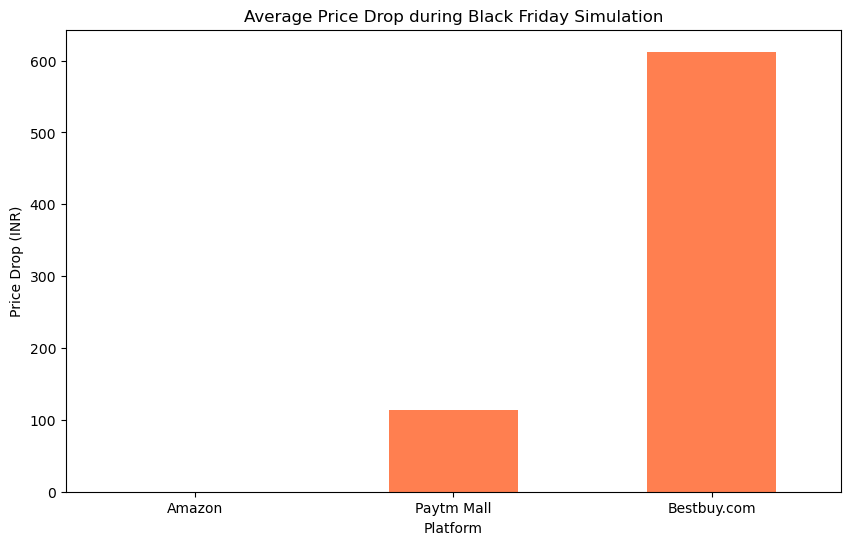

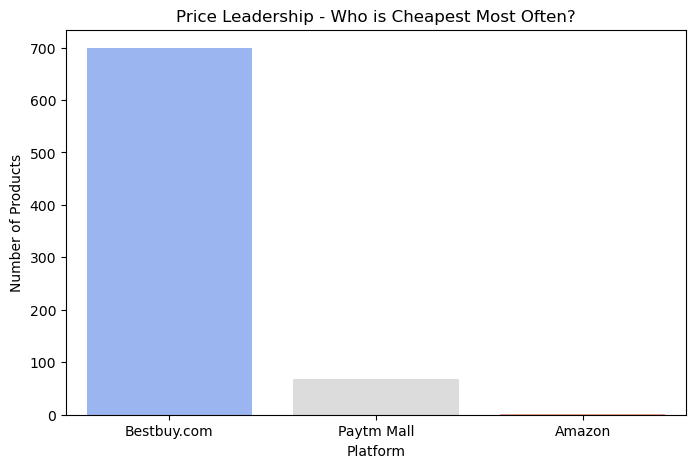

In [17]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the competitor comparison data
pivot_df = pd.read_csv('competitor_price_comparison.csv')

# 1️⃣ Simulate promotions: assume certain categories during "Black Friday" or "Cyber Monday" get discounts

# Let's randomly select 20% of the products and apply a 10-30% discount to simulate a sale
np.random.seed(42)  # for reproducibility
sale_products = pivot_df.sample(frac=0.2)

# Create a copy to simulate Black Friday sales
black_friday_df = pivot_df.copy()

# Apply random discounts
for idx in sale_products.index:
    for platform in ['Amazon', 'Paytm Mall', 'Bestbuy.com']:
        if not pd.isna(black_friday_df.loc[idx, platform]):
            discount = np.random.uniform(0.10, 0.30)  # between 10% to 30%
            black_friday_df.loc[idx, platform] = black_friday_df.loc[idx, platform] * (1 - discount)

# Save the simulated Black Friday data (optional)
black_friday_df.to_csv('black_friday_pricing_simulation.csv', index=False)

# Plot: Effect of Discounts
plt.figure(figsize=(10,6))
price_drop = pivot_df[['Amazon', 'Paytm Mall', 'Bestbuy.com']].mean() - black_friday_df[['Amazon', 'Paytm Mall', 'Bestbuy.com']].mean()
price_drop.plot(kind='bar', color='coral')
plt.title('Average Price Drop during Black Friday Simulation')
plt.ylabel('Price Drop (INR)')
plt.xlabel('Platform')
plt.xticks(rotation=0)
plt.show()

# 2️⃣ Detect Price Leadership: who sets the lowest price for the most products

# From original (not simulated) data
pivot_df['cheapest_platform'] = pivot_df[['Amazon', 'Paytm Mall', 'Bestbuy.com']].idxmin(axis=1)
leadership_counts = pivot_df['cheapest_platform'].value_counts()

# Plot Price Leadership
plt.figure(figsize=(8,5))
sns.barplot(x=leadership_counts.index, y=leadership_counts.values, palette='coolwarm')
plt.title('Price Leadership - Who is Cheapest Most Often?')
plt.ylabel('Number of Products')
plt.xlabel('Platform')
plt.show()